The Government of Canada: https://fintrac-canafe.canada.ca/intro-eng
The Financial Transactions and Reports Analysis Centre of Canada (FINTRAC) is Canada's financial intelligence unit and anti-money laundering and anti-terrorist financing supervisor. Its mandate is to facilitate the detection, prevention and deterrence of money laundering and the financing of terrorist activities, while ensuring the protection of personal information under its control.

The Government of Canada: https://fintrac-canafe.canada.ca/individuals-individus/rpt-eng#
Electronic funds transfers (EFTs) - an electronic funds transfer report must be submitted to FINTRAC upon a transmission of instructions for the transfer of $10,000 or more out of, or into, Canada in a single transaction; or in two or more transactions totalling $10,000 or more made within 24 consecutive hours by or on behalf of the same person or entity, through any electronic, magnetic or optical device, telephone instrument or computer.

SWIFT is a global cooperative of financial institutions that handle cross-border payments.

In [342]:
import pandas as pd
import numpy as np
from datetime import datetime

------------------------------
EDA & data cleaning: eft.csv
Raw data for all EFT transactions from the admin system for the full audit period (“eft.csv”).
------------------------------

In [343]:
eft = pd.read_csv('eft.csv')
eft.head()

,CIF,EFFECTIVE_DATE,TRANSACTION_AMOUNT,TRANSACTION_CODE,TRANSACTION_DECRIPTION,TIME_SEQ
0,3300125,21-Jul-20,108880.95,CM,Deposit,8:44:26
1,2616067,21-Jul-20,-1200000.00,DM,Funds Wired to/from,10:09:05
2,3233547,21-Jul-20,-15000.00,DM,Funds Wired to/from,15:18:22
3,2372206,21-Jul-20,362452.27,CM,Funds Wired to/from,12:11:03
4,2274624,21-Jul-20,217794.43,CM,Funds Wired to/from,11:34:49


In [344]:
eft.info()
# CIF: 7-digit number, unique identifier
# EFFECTIVE_DATE: to convert from object into datetime dtype
# TRANSACTION_AMOUNT: $
# TRANSACTION_CODE: are there categories? 
# TRANSACTION_DECRIPTION: are there categories? 
# TIME_SEQ: to convert from object into datetime dtype

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137067 entries, 0 to 137066
Data columns (total 6 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   CIF                     137067 non-null  int64  
 1   EFFECTIVE_DATE          137067 non-null  object 
 2   TRANSACTION_AMOUNT      137067 non-null  float64
 3   TRANSACTION_CODE        137067 non-null  object 
 4   TRANSACTION_DECRIPTION  137067 non-null  object 
 5   TIME_SEQ                137067 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.3+ MB


In [345]:
eft.isna().sum()

CIF                       0
EFFECTIVE_DATE            0
TRANSACTION_AMOUNT        0
TRANSACTION_CODE          0
TRANSACTION_DECRIPTION    0
TIME_SEQ                  0
dtype: int64

In [346]:
# EFFECTIVE_DATE
eft['EFFECTIVE_DATE'] = pd.to_datetime(eft['EFFECTIVE_DATE'], format='%d-%b-%y', errors='coerce') # '21-Jul-20': '%d-%b-%y' format 
eft['EFFECTIVE_DATE'].head()

0   2020-07-21
1   2020-07-21
2   2020-07-21
3   2020-07-21
4   2020-07-21
Name: EFFECTIVE_DATE, dtype: datetime64[ns]

In [347]:
# What's the eft data timeframe/ full audit period? 
eft_start = eft['EFFECTIVE_DATE'].min()
eft_finish = eft['EFFECTIVE_DATE'].max()
print('eft transactions from', eft_start, 'to', eft_finish)
# The eft transactions data is for 1 year period: from Oct 1, 2019 to Sept 30, 2020. 

eft transactions from 2019-10-01 00:00:00 to 2020-09-30 00:00:00


In [348]:
# TRANSACTION_CODE
eft['TRANSACTION_CODE'].value_counts()
# TRANSACTION_CODE has 2 categories: DM and CM

TRANSACTION_CODE
DM    72564
CM    64503
Name: count, dtype: int64

In [349]:
# TRANSACTION_DECRIPTION
eft['TRANSACTION_DECRIPTION'].value_counts()
# there are 128 different transaction descriptions

TRANSACTION_DECRIPTION
Funds Wired to/from              21382
Returned Item                    12768
Credit Memo                      10892
Debit Memo                        9815
Advance                           7177
                                 ...  
One Account Payment                  1
REV One Account Payment              1
REV Reverse Bank Confirmation        1
Reverse Bank Confirmation            1
Voucher Search                       1
Name: count, Length: 128, dtype: int64

In [350]:
# let's check if SWIFT is in TRANSACTION_DECRIPTION
eft['TRANSACTION_DECRIPTION'].str.contains("SWIFT", case=False).sum()
# swift is not in the description

0

In [351]:
# SWIFT is a global cooperative of financial institutions that handle cross-border payments
# since there no SWIFT indication in description, and no clear direction how to identify SWIFT, I'll do a manual look in order to identify international transactions 
# Note: in real life I would connect to a business unit and ask for clarification

pd.unique(eft['TRANSACTION_DECRIPTION'])

# The following transactions were idetified:
# 'International Wire', 'US International Wire', 'International Wire BoC'

# same transaction descriptions but reversed (REV) - so will not be included: 'REV International Wire', 'REV International Wire BoC'

array(['Deposit', 'Funds Wired to/from', 'REV LOC Payment',
       'Rev. External Transfer', 'REV Elect. Funds Transfer',
       'International Wire', 'Returned Item', 'Registration Cost',
       'Discharge Administration Fee', 'Advanced',
       'REV Misc Service Charge', 'Debit Memo', 'U.S. Wire Transfer',
       'Card Adjustment', 'Rev. Bill Payment',
       'Underwriting Fee - Select', 'Credit Memo', 'ABM Adjustment',
       'Insurance + PST', 'REV Underwriting HST', 'Promotion', 'Advance',
       'Adjustment', 'Misc Service Charge', 'Legal Fees',
       'Underwriting HST', 'Elect. Funds Transfer', 'Processing Fees',
       'REV Credit Memo', 'Account Holder Change Fee', 'LOC Payment',
       'Invalid Cheque Fee', 'Rev. Deposit', 'Mobile Deposit Adjustment',
       'REV Registration Cost', 'Interest Adjustment',
       'Rev. Official Cheque', 'Underwriting Fee - M-One', 'REV Advance',
       'REV Deposit', 'REV Funds Wired to/from', 'REV NSF Charge',
       'Overdraft Fee', 'REV In

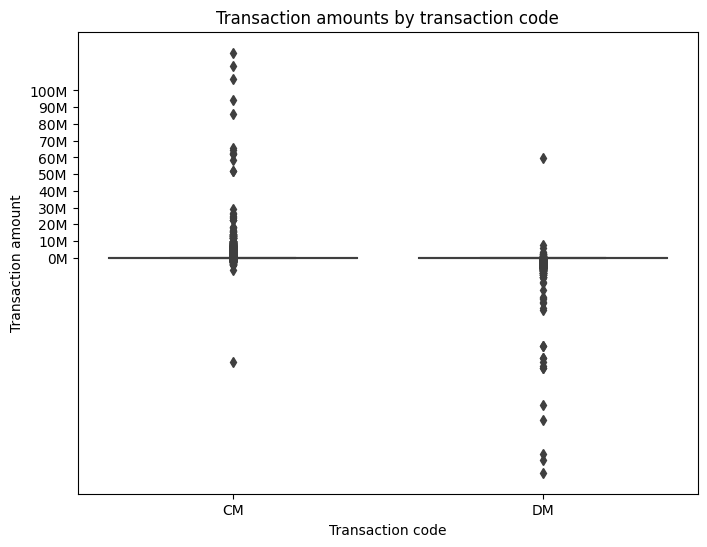

In [352]:
# to have an idea what DM and CM are, let's see if there is a pattern between 'TRANSACTION_AMOUNT' and 'TRANSACTION_CODE'
import matplotlib.pyplot as plt
import seaborn as sns

dm_trans = eft[eft['TRANSACTION_CODE'] == 'DM']['TRANSACTION_AMOUNT']
cm_trans = eft[eft['TRANSACTION_CODE'] == 'CM']['TRANSACTION_AMOUNT']

plt.figure(figsize=(8, 6))
sns.boxplot(x='TRANSACTION_CODE', y='TRANSACTION_AMOUNT', data=eft)
plt.xlabel('Transaction code')
plt.ylabel('Transaction amount')
plt.title('Transaction amounts by transaction code')
yticks = [0, 10000000, 20000000, 30000000, 40000000, 50000000, 60000000, 70000000, 80000000, 90000000, 100000000]  
plt.yticks(yticks, labels=[f'{int(val / 1000000)}M' for val in yticks])
plt.show()

# CM: mostly positive values - 'money in' ?
# DM: mostly negative values - 'money out' ?
# However, both CM and DM have the opposite values - might be reversed transactions.
# All these concerns would be confirmed with a busines unit in real project.

# since SWIFT (cross-border payments) can be both - money in and money out, I will look at both + and - amounts

In [353]:
# TIME_SEQ
eft['TIME_SEQ'] = pd.to_datetime(eft['TIME_SEQ'], format='%H:%M:%S', errors='coerce') # '15:18:22': '%H:%M:%S' format
eft['TIME_SEQ'].head()
# 1900-01-01 is defaut time, we'll get rid of it when we merge date and time of the transaction into one column 

0   1900-01-01 08:44:26
1   1900-01-01 10:09:05
2   1900-01-01 15:18:22
3   1900-01-01 12:11:03
4   1900-01-01 11:34:49
Name: TIME_SEQ, dtype: datetime64[ns]

In [354]:
#  merge EFFECTIVE_DATE and TIME_SEQ into one column TRANS_DATETIME
eft['TRANS_DATETIME'] = eft['EFFECTIVE_DATE'].dt.strftime('%Y-%m-%d') + ' ' + eft['TIME_SEQ'].dt.strftime('%H:%M:%S')
eft['TRANS_DATETIME'] = pd.to_datetime(eft['TRANS_DATETIME'],format="%Y-%m-%d %H:%M:%S", errors='coerce')
eft['TRANS_DATETIME'].head()

0   2020-07-21 08:44:26
1   2020-07-21 10:09:05
2   2020-07-21 15:18:22
3   2020-07-21 12:11:03
4   2020-07-21 11:34:49
Name: TRANS_DATETIME, dtype: datetime64[ns]

------------------------------
EDA & data cleaning: fintrac_reported.xlsx
Transactions that Business reported to FINTRAC during the audit period (“fintrac_reported.xlsx”)
------------------------------

In [355]:
fintrac = pd.read_excel('fintrac_reported.xlsx')
fintrac.head(20)

,Report Ref,Filing Date,Report Type,Tran Date,Tran Time,Tran Amt,Tran Cur,Client ID
0,EFTO2019080100001001,2019-08-01,EFTO,2019-07-30,153443,28000.0,CAD,2286141
1,EFTO2019080100001002,2019-08-01,EFTO,2019-07-30,153443,10000.0,CAD,2456977
2,EFTO2019080100001003,2019-08-01,EFTO,2019-07-31,132351,23690.0,USD,3182054
3,EFTO2019080200001001,2019-08-02,EFTO,2019-08-01,154452,20000.0,CAD,3193091
4,EFTO2019080600001001,2019-08-06,EFTO,2019-08-02,134746,33436.0,CAD,2911297
5,EFTO2019080600001002,2019-08-06,EFTO,2019-08-02,135350,22000.0,CAD,2621260
6,EFTI2019080600002001,2019-08-06,EFTI,2019-08-02,0,12314.0,CAD,2555646
7,EFTO2019080700001001,2019-08-07,EFTO,2019-08-01,154452,11453.0,CAD,2457710
8,EFTO2019080700001002,2019-08-07,EFTO,2019-08-06,154124,12000.0,CAD,2489392
9,EFTI2019080700002001,2019-08-07,EFTI,2019-08-06,0,11500.0,CAD,2429120


In [356]:
fintrac.info()
# Report Ref: EFT unique identifier
# Filing Date: to convert from object into datetime dtype 
# Report Type: are there categories?
# Tran Date: to convert from object into datetime dtype 
# Tran Time: to convert from int64 into datetime dtype. Some of the values are 0 and need to be 00:00:00 
# Tran Amt: $ 
# Tran Cur: are there categories?
# Client ID: 7-digit number, unique identifier. I assume that it's same as CIF in eft data 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 867 entries, 0 to 866
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Report Ref   867 non-null    object 
 1   Filing Date  867 non-null    object 
 2   Report Type  867 non-null    object 
 3   Tran Date    867 non-null    object 
 4   Tran Time    867 non-null    int64  
 5   Tran Amt     867 non-null    float64
 6   Tran Cur     867 non-null    object 
 7   Client ID    867 non-null    int64  
dtypes: float64(1), int64(2), object(5)
memory usage: 54.3+ KB


In [357]:
# check for missing values 
fintrac.isna().sum()

Report Ref     0
Filing Date    0
Report Type    0
Tran Date      0
Tran Time      0
Tran Amt       0
Tran Cur       0
Client ID      0
dtype: int64

In [358]:
# check for duplicates 
dupl = fintrac.duplicated()
print(dupl.value_counts())

False    867
Name: count, dtype: int64


In [359]:
# Filing Date 
fintrac['Filing Date'] = pd.to_datetime(fintrac['Filing Date'], format='%Y-%m-%d', errors='coerce') # '2019-08-01': '%Y-%m-%d' format 
fintrac['Filing Date'].head()

0   2019-08-01
1   2019-08-01
2   2019-08-01
3   2019-08-02
4   2019-08-06
Name: Filing Date, dtype: datetime64[ns]

In [360]:
# Report Type
fintrac['Report Type'].value_counts()

Report Type
EFTO    469
EFTI    398
Name: count, dtype: int64

In [361]:
# Tran Date
fintrac['Tran Date'] = pd.to_datetime(fintrac['Tran Date'], format='%Y-%m-%d', errors='coerce') # '2019-07-30': '%Y-%m-%d' format 
fintrac['Tran Date'].head()

0   2019-07-30
1   2019-07-30
2   2019-07-31
3   2019-08-01
4   2019-08-02
Name: Tran Date, dtype: datetime64[ns]

In [362]:
# What's the timeframe for Tran Time in fintraac df?
fintrac_start = fintrac['Tran Date'].min()
fintrac_finish = fintrac['Tran Date'].max()
print('fintrac transactions from', fintrac_start, 'to', fintrac_finish)

# fintrac transactions are from July 30, 2019 to Sept 25, 2020.
# There is a discrepancy with the eft transactions data which is from Oct 1, 2019 to Sept 30, 2020, we need to keep it in mind. 

fintrac transactions from 2019-07-30 00:00:00 to 2020-09-25 00:00:00


In [363]:
# Tran Time
# replace 0 values with '000000' before conversion
fintrac['Tran Time'] = fintrac['Tran Time'].replace(0, '000000')
fintrac['Tran Time'] = pd.to_datetime(fintrac['Tran Time'], format='%H%M%S', errors='coerce') # '153443': '%H%M%S' format
fintrac['Tran Time'].head(10)

0   1900-01-01 15:34:43
1   1900-01-01 15:34:43
2   1900-01-01 13:23:51
3   1900-01-01 15:44:52
4   1900-01-01 13:47:46
5   1900-01-01 13:53:50
6   1900-01-01 00:00:00
7   1900-01-01 15:44:52
8   1900-01-01 15:41:24
9   1900-01-01 00:00:00
Name: Tran Time, dtype: datetime64[ns]

In [364]:
# merge 'Tran Date' and 'Tran Time' into 'Tran Date Time'
fintrac['Tran Date Time'] = fintrac['Tran Date'].dt.strftime('%Y-%m-%d') + ' ' + fintrac['Tran Time'].dt.strftime('%H%M%S')
fintrac['Tran Date Time'] = pd.to_datetime(fintrac['Tran Date Time'],format="%Y-%m-%d %H%M%S", errors='coerce')
fintrac['Tran Date Time'].head()

0   2019-07-30 15:34:43
1   2019-07-30 15:34:43
2   2019-07-31 13:23:51
3   2019-08-01 15:44:52
4   2019-08-02 13:47:46
Name: Tran Date Time, dtype: datetime64[ns]

In [365]:
# Tran Cur
fintrac['Tran Cur'].value_counts()

Tran Cur
CAD    787
USD     80
Name: count, dtype: int64

In [366]:
fintrac.head(10)

,Report Ref,Filing Date,Report Type,Tran Date,Tran Time,Tran Amt,Tran Cur,Client ID,Tran Date Time
0,EFTO2019080100001001,2019-08-01,EFTO,2019-07-30,1900-01-01 15:34:43,28000.0,CAD,2286141,2019-07-30 15:34:43
1,EFTO2019080100001002,2019-08-01,EFTO,2019-07-30,1900-01-01 15:34:43,10000.0,CAD,2456977,2019-07-30 15:34:43
2,EFTO2019080100001003,2019-08-01,EFTO,2019-07-31,1900-01-01 13:23:51,23690.0,USD,3182054,2019-07-31 13:23:51
3,EFTO2019080200001001,2019-08-02,EFTO,2019-08-01,1900-01-01 15:44:52,20000.0,CAD,3193091,2019-08-01 15:44:52
4,EFTO2019080600001001,2019-08-06,EFTO,2019-08-02,1900-01-01 13:47:46,33436.0,CAD,2911297,2019-08-02 13:47:46
5,EFTO2019080600001002,2019-08-06,EFTO,2019-08-02,1900-01-01 13:53:50,22000.0,CAD,2621260,2019-08-02 13:53:50
6,EFTI2019080600002001,2019-08-06,EFTI,2019-08-02,1900-01-01 00:00:00,12314.0,CAD,2555646,2019-08-02 00:00:00
7,EFTO2019080700001001,2019-08-07,EFTO,2019-08-01,1900-01-01 15:44:52,11453.0,CAD,2457710,2019-08-01 15:44:52
8,EFTO2019080700001002,2019-08-07,EFTO,2019-08-06,1900-01-01 15:41:24,12000.0,CAD,2489392,2019-08-06 15:41:24
9,EFTI2019080700002001,2019-08-07,EFTI,2019-08-06,1900-01-01 00:00:00,11500.0,CAD,2429120,2019-08-06 00:00:00


In [367]:
fintrac.isna().sum()

Report Ref        0
Filing Date       0
Report Type       0
Tran Date         0
Tran Time         0
Tran Amt          0
Tran Cur          0
Client ID         0
Tran Date Time    0
dtype: int64

Since FINTRAC is a Canadian institution, the currency needs to be in CAD. 
Given that the conversion rate fluctuated over time from July 30, 2019 to Sept 25, 2020, 
I got the historical exchange rate data for the audit time period from USD to CAD from https://www.bankofcanada.ca/rates/exchange/daily-exchange-rates/

In [368]:
usd_cad = pd.read_csv('BOC_daily_exchange_rates.csv')
print(usd_cad)
# Note: the exchage rates on the weekends are missing since the markets are closed. 

           Date  Exchange Rate
0    2019-07-30         1.3168
1    2019-07-31         1.3148
2    2019-08-01         1.3217
3    2019-08-02         1.3225
4    2019-08-06         1.3253
..          ...            ...
286  2020-09-21         1.3293
287  2020-09-22         1.3310
288  2020-09-23         1.3358
289  2020-09-24         1.3374
290  2020-09-25         1.3396

[291 rows x 2 columns]


In [369]:
# convert Date into datetime dtype 
usd_cad['Date'] = pd.to_datetime(usd_cad['Date'], format='%Y-%m-%d', errors='coerce') # '%Y-%m-%d' format 
usd_cad['Date'].head()

0   2019-07-30
1   2019-07-31
2   2019-08-01
3   2019-08-02
4   2019-08-06
Name: Date, dtype: datetime64[ns]

In [370]:
# to add weekends and exchange rate for the weekend , I'll do the following steps:
# 1. create a calendar_dates table for dates from 2019-08-30 to 2020-09-25
# 2. merge the calendar_dates table with usa_cad on left join
# 3. fill in the missing exchange rate with previous date exchange rate

# Note: in real life different banks have different policies in place that specify the exchange rate on the weeekends, 
# the rule of thumb is to sell the currency on a higher price than the last rate on the time when the market closed to mitigate the risks,
# but since I don't have any guideance, I'll use the last known rate

# 1. create a calendar_dates table
def create_calendar_dates(start_date='2019-07-30', end_date='2020-09-25'):
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    date_range = pd.date_range(start=start_date, end=end_date)
    calendar_dates = pd.DataFrame({'date': date_range})
    return calendar_dates

calendar_dates = create_calendar_dates()
print(calendar_dates)

          date
0   2019-07-30
1   2019-07-31
2   2019-08-01
3   2019-08-02
4   2019-08-03
..         ...
419 2020-09-21
420 2020-09-22
421 2020-09-23
422 2020-09-24
423 2020-09-25

[424 rows x 1 columns]


In [371]:
# 2. merge tables 
usd_cad = calendar_dates.merge(usd_cad, how='left', left_on='date', right_on='Date')
print(usd_cad)

          date       Date  Exchange Rate
0   2019-07-30 2019-07-30         1.3168
1   2019-07-31 2019-07-31         1.3148
2   2019-08-01 2019-08-01         1.3217
3   2019-08-02 2019-08-02         1.3225
4   2019-08-03        NaT            NaN
..         ...        ...            ...
419 2020-09-21 2020-09-21         1.3293
420 2020-09-22 2020-09-22         1.3310
421 2020-09-23 2020-09-23         1.3358
422 2020-09-24 2020-09-24         1.3374
423 2020-09-25 2020-09-25         1.3396

[424 rows x 3 columns]


In [372]:
# 3 fill in missing exchange rates 

def fill_missing_prices(usd_cad):
    usd_cad['Exchange Rate'].fillna(method='ffill', inplace=True) # 'ffill' replaces missing values with the value from the previous row
    return usd_cad

usd_cad = fill_missing_prices(usd_cad.copy())
print(usd_cad)

          date       Date  Exchange Rate
0   2019-07-30 2019-07-30         1.3168
1   2019-07-31 2019-07-31         1.3148
2   2019-08-01 2019-08-01         1.3217
3   2019-08-02 2019-08-02         1.3225
4   2019-08-03        NaT         1.3225
..         ...        ...            ...
419 2020-09-21 2020-09-21         1.3293
420 2020-09-22 2020-09-22         1.3310
421 2020-09-23 2020-09-23         1.3358
422 2020-09-24 2020-09-24         1.3374
423 2020-09-25 2020-09-25         1.3396

[424 rows x 3 columns]


/var/folders/w4/f8rg8p610t3bch11xq78chv80000gn/T/ipykernel_60229/4259304266.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  usd_cad['Exchange Rate'].fillna(method='ffill', inplace=True) # 'ffill' replaces missing values with the value from the previous row
/var/folders/w4/f8rg8p610t3bch11xq78chv80000gn/T/ipykernel_60229/4259304266.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  usd_cad['Exchange Rate'].fillna(method='ffill', inplac

In [373]:
# drop Date column 
usd_cad = usd_cad.drop(columns=['Date'], inplace=False)
usd_cad

,date,Exchange Rate
0,2019-07-30,1.3168
1,2019-07-31,1.3148
2,2019-08-01,1.3217
3,2019-08-02,1.3225
4,2019-08-03,1.3225
...,...,...
419,2020-09-21,1.3293
420,2020-09-22,1.3310
421,2020-09-23,1.3358
422,2020-09-24,1.3374


In [374]:
usd_cad.dtypes

date             datetime64[ns]
Exchange Rate           float64
dtype: object

In [375]:
# I just want to rename columns before merging for easy reference
usd_cad = usd_cad.rename(columns={'date': 'Exchange Date'})

In [376]:
# merge fintrac and usd_cad based on date
fintrac = fintrac.reset_index(drop=True)  # drop index
usd_cad = usd_cad.reset_index(drop=True) # drop index

fintrac_cad = fintrac.merge(usd_cad, how='left', left_on='Tran Date', right_on='Exchange Date')
fintrac_cad


,Report Ref,Filing Date,Report Type,Tran Date,Tran Time,Tran Amt,Tran Cur,Client ID,Tran Date Time,Exchange Date,Exchange Rate
0,EFTO2019080100001001,2019-08-01,EFTO,2019-07-30,1900-01-01 15:34:43,28000.00,CAD,2286141,2019-07-30 15:34:43,2019-07-30,1.3168
1,EFTO2019080100001002,2019-08-01,EFTO,2019-07-30,1900-01-01 15:34:43,10000.00,CAD,2456977,2019-07-30 15:34:43,2019-07-30,1.3168
2,EFTO2019080100001003,2019-08-01,EFTO,2019-07-31,1900-01-01 13:23:51,23690.00,USD,3182054,2019-07-31 13:23:51,2019-07-31,1.3148
3,EFTO2019080200001001,2019-08-02,EFTO,2019-08-01,1900-01-01 15:44:52,20000.00,CAD,3193091,2019-08-01 15:44:52,2019-08-01,1.3217
4,EFTO2019080600001001,2019-08-06,EFTO,2019-08-02,1900-01-01 13:47:46,33436.00,CAD,2911297,2019-08-02 13:47:46,2019-08-02,1.3225
...,...,...,...,...,...,...,...,...,...,...,...
862,EFTI2020092400002002,2020-09-24,EFTI,2020-09-22,1900-01-01 00:00:00,20432.96,CAD,2381375,2020-09-22 00:00:00,2020-09-22,1.3310
863,EFTI2020092500001001,2020-09-25,EFTI,2020-09-23,1900-01-01 00:00:00,32573.68,CAD,2462805,2020-09-23 00:00:00,2020-09-23,1.3358
864,EFTI2020092500001002,2020-09-25,EFTI,2020-09-22,1900-01-01 00:00:00,4913.93,CAD,3221652,2020-09-22 00:00:00,2020-09-22,1.3310
865,EFTI2020092500001003,2020-09-25,EFTI,2020-09-23,1900-01-01 00:00:00,59999.73,CAD,3221652,2020-09-23 00:00:00,2020-09-23,1.3358


In [377]:
# checking if there are any missing values 
fintrac_cad.isna().sum()

Report Ref        0
Filing Date       0
Report Type       0
Tran Date         0
Tran Time         0
Tran Amt          0
Tran Cur          0
Client ID         0
Tran Date Time    0
Exchange Date     0
Exchange Rate     0
dtype: int64

In [378]:
# convert USD transactions into CAD
usd_tran = fintrac_cad[fintrac_cad['Tran Cur'] == 'USD']
usd_tran['Tran Amt'] = usd_tran['Tran Amt'] * usd_tran['Exchange Rate']

# update fintrac_cad and replace usd transacion amounts and currency with CAD
fintrac_cad.loc[usd_tran.index, 'Tran Amt'] = usd_tran['Tran Amt']
fintrac_cad.loc[usd_tran.index, 'Tran Cur'] = 'CAD'
print(fintrac_cad)

               Report Ref Filing Date Report Type  Tran Date  \
0    EFTO2019080100001001  2019-08-01        EFTO 2019-07-30   
1    EFTO2019080100001002  2019-08-01        EFTO 2019-07-30   
2    EFTO2019080100001003  2019-08-01        EFTO 2019-07-31   
3    EFTO2019080200001001  2019-08-02        EFTO 2019-08-01   
4    EFTO2019080600001001  2019-08-06        EFTO 2019-08-02   
..                    ...         ...         ...        ...   
862  EFTI2020092400002002  2020-09-24        EFTI 2020-09-22   
863  EFTI2020092500001001  2020-09-25        EFTI 2020-09-23   
864  EFTI2020092500001002  2020-09-25        EFTI 2020-09-22   
865  EFTI2020092500001003  2020-09-25        EFTI 2020-09-23   
866  EFTO2020092900001001  2020-09-29        EFTO 2020-09-25   

              Tran Time   Tran Amt Tran Cur  Client ID      Tran Date Time  \
0   1900-01-01 15:34:43  28000.000      CAD    2286141 2019-07-30 15:34:43   
1   1900-01-01 15:34:43  10000.000      CAD    2456977 2019-07-30 15:34:43 

/var/folders/w4/f8rg8p610t3bch11xq78chv80000gn/T/ipykernel_60229/3577929756.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usd_tran['Tran Amt'] = usd_tran['Tran Amt'] * usd_tran['Exchange Rate']


------------------------------
EFT-SWIFT transactions must be reported to FINTRAC if one of the following conditions is met:
- Single EFT transactions with SWIFT transaction type exceeding $10,000;
- Two or more EFT-SWIFT transactions that were made within 24 hours (less than $10,000 each) exceeding $10,000 in total.
------------------------------

In [379]:
eft.head()

,CIF,EFFECTIVE_DATE,TRANSACTION_AMOUNT,TRANSACTION_CODE,TRANSACTION_DECRIPTION,TIME_SEQ,TRANS_DATETIME
0,3300125,2020-07-21,108880.95,CM,Deposit,1900-01-01 08:44:26,2020-07-21 08:44:26
1,2616067,2020-07-21,-1200000.00,DM,Funds Wired to/from,1900-01-01 10:09:05,2020-07-21 10:09:05
2,3233547,2020-07-21,-15000.00,DM,Funds Wired to/from,1900-01-01 15:18:22,2020-07-21 15:18:22
3,2372206,2020-07-21,362452.27,CM,Funds Wired to/from,1900-01-01 12:11:03,2020-07-21 12:11:03
4,2274624,2020-07-21,217794.43,CM,Funds Wired to/from,1900-01-01 11:34:49,2020-07-21 11:34:49


In [380]:
# let's crate a subset from eft df for SWIFT transactions:
# 'International Wire', 'US International Wire', 'International Wire BoC'

swift_eft = eft[eft['TRANSACTION_DECRIPTION'].isin(['International Wire', 'US International Wire', 'International Wire BoC'])]
print(swift_eft)

            CIF EFFECTIVE_DATE  TRANSACTION_AMOUNT TRANSACTION_CODE  \
14      2462805     2020-07-24            16161.13               CM   
16      2495504     2020-07-24               60.99               CM   
56      2674126     2020-07-13           -13200.00               DM   
70      2149604     2020-07-16           -27549.56               DM   
104     3043238     2020-07-16            -4781.10               DM   
...         ...            ...                 ...              ...   
136589  3292029     2020-09-29             3977.09               CM   
136840  2374750     2020-09-30           -58515.92               DM   
136935  2659416     2020-09-30             -916.50               DM   
137038  2158848     2020-09-30           -10255.36               DM   
137060  3070027     2020-09-30          -128810.88               DM   

       TRANSACTION_DECRIPTION            TIME_SEQ      TRANS_DATETIME  
14         International Wire 1900-01-01 11:46:44 2020-07-24 11:46:44  
16 

In [381]:
# identify single transactions exceeding $10,000 
# since we're asked to report all transactions, in and out, we'll look for both + and - transactions (abs values) 
single_swift = swift_eft[abs(swift_eft['TRANSACTION_AMOUNT']) > 10000] 
print(single_swift)
# 810 over 10,000 or -10,000

            CIF EFFECTIVE_DATE  TRANSACTION_AMOUNT TRANSACTION_CODE  \
14      2462805     2020-07-24            16161.13               CM   
56      2674126     2020-07-13           -13200.00               DM   
70      2149604     2020-07-16           -27549.56               DM   
106     2638391     2020-07-16           -15937.00               DM   
298     3292029     2020-07-30            28724.61               CM   
...         ...            ...                 ...              ...   
136441  2829976     2020-09-29            25942.52               CM   
136578  2625588     2020-09-29            18344.72               CM   
136840  2374750     2020-09-30           -58515.92               DM   
137038  2158848     2020-09-30           -10255.36               DM   
137060  3070027     2020-09-30          -128810.88               DM   

       TRANSACTION_DECRIPTION            TIME_SEQ      TRANS_DATETIME  
14         International Wire 1900-01-01 11:46:44 2020-07-24 11:46:44  
56 

Verify if the bank has reported all single_swift transactions timely (reporting date is expected to be the same as transaction date) 
and accurately (reported transaction date and amount must be matching eft data).

In [382]:
# merge single_swift and fintrac_cad df using left merge
single_swift_reported = pd.merge(
    single_swift[['CIF', 'EFFECTIVE_DATE', 'TRANSACTION_AMOUNT', 'TRANSACTION_DECRIPTION']],
    fintrac_cad[['Report Ref', 'Client ID', 'Filing Date', 'Tran Date', 'Tran Amt']],
    left_on=['CIF', 'EFFECTIVE_DATE', 'TRANSACTION_AMOUNT'], right_on=['Client ID', 'Tran Date', 'Tran Amt'], 
    how='left')
print(single_swift_reported)

         CIF EFFECTIVE_DATE  TRANSACTION_AMOUNT TRANSACTION_DECRIPTION  \
0    2462805     2020-07-24            16161.13     International Wire   
1    2674126     2020-07-13           -13200.00     International Wire   
2    2149604     2020-07-16           -27549.56     International Wire   
3    2638391     2020-07-16           -15937.00     International Wire   
4    3292029     2020-07-30            28724.61     International Wire   
..       ...            ...                 ...                    ...   
805  2829976     2020-09-29            25942.52     International Wire   
806  2625588     2020-09-29            18344.72     International Wire   
807  2374750     2020-09-30           -58515.92  US International Wire   
808  2158848     2020-09-30           -10255.36     International Wire   
809  3070027     2020-09-30          -128810.88     International Wire   

               Report Ref  Client ID Filing Date  Tran Date  Tran Amt  
0    EFTI2020072900001001  2462805.0  2

In [383]:
# the number of NaN will be the number of transactions that were not reported timely and accurately 
single_swift_not_reported = single_swift_reported[single_swift_reported['Report Ref'].isna()]
print(single_swift_not_reported)
# 610 transactions were not reported timely or accurately

# to do a spot check of transactions with a business unit 

         CIF EFFECTIVE_DATE  TRANSACTION_AMOUNT TRANSACTION_DECRIPTION  \
1    2674126     2020-07-13           -13200.00     International Wire   
2    2149604     2020-07-16           -27549.56     International Wire   
3    2638391     2020-07-16           -15937.00     International Wire   
7    2516410     2020-07-30          -460665.00     International Wire   
12   3237736     2020-07-28            13500.00  US International Wire   
..       ...            ...                 ...                    ...   
805  2829976     2020-09-29            25942.52     International Wire   
806  2625588     2020-09-29            18344.72     International Wire   
807  2374750     2020-09-30           -58515.92  US International Wire   
808  2158848     2020-09-30           -10255.36     International Wire   
809  3070027     2020-09-30          -128810.88     International Wire   

    Report Ref  Client ID Filing Date Tran Date  Tran Amt  
1          NaN        NaN         NaT       NaT    

In [384]:
# exploring transactions that were not reported timely or accurately 

# TRANSACTION_DECRIPTION 
single_swift_not_reported['TRANSACTION_DECRIPTION'].value_counts()

TRANSACTION_DECRIPTION
International Wire       544
US International Wire     66
Name: count, dtype: int64

In [385]:
# distribution of positive and negative transactions
positive_single_swift = single_swift_not_reported[single_swift_not_reported['TRANSACTION_AMOUNT'] > 0]
negative_single_swift = single_swift_not_reported[single_swift_not_reported['TRANSACTION_AMOUNT'] < 0]
positive_single_swift.count() #230 transactions exceeding $10,000 
negative_single_swift.count() #380 transactions exceeding -$10,000

CIF                       380
EFFECTIVE_DATE            380
TRANSACTION_AMOUNT        380
TRANSACTION_DECRIPTION    380
Report Ref                  0
Client ID                   0
Filing Date                 0
Tran Date                   0
Tran Amt                    0
dtype: int64

In [386]:
# now we can save the output into a scv file for further spotcheck/ present to business unit
#single_swift_reported.to_csv('single_swift_reported.csv', index=False)

Identify two or more transactions that were made within 24 hours (less than $10,000 each) exceeding $10,000 in total

In [387]:
# filter transactions less than $10,000 in absolute value
df_filtered = swift_eft[abs(swift_eft['TRANSACTION_AMOUNT']) < 10000]

# group by CIF and EFFECTIVE_DATE and calculate the sum of transaction amounts for + and - amounts separately 
grouped = df_filtered.groupby(['CIF', 'EFFECTIVE_DATE']).agg(
    total_positive_amount=pd.NamedAgg(column='TRANSACTION_AMOUNT', aggfunc=lambda x: x[x > 0].sum()),
    total_negative_amount=pd.NamedAgg(column='TRANSACTION_AMOUNT', aggfunc=lambda x: x[x < 0].sum())
).reset_index()

# check conditions
grouped['POSITIVE_OVER_10000'] = grouped['total_positive_amount'] > 10000
grouped['NEGATIVE_UNDER_MINUS_10000'] = grouped['total_negative_amount'] < -10000

filtered = grouped[(grouped['POSITIVE_OVER_10000']) | (grouped['NEGATIVE_UNDER_MINUS_10000'])]

# merge filtered data with original df to get all transaction details
mult_swift = swift_eft.merge(filtered[['CIF', 'EFFECTIVE_DATE']], on=['CIF', 'EFFECTIVE_DATE'])

print(mult_swift)
# 15 transactions 

        CIF EFFECTIVE_DATE  TRANSACTION_AMOUNT TRANSACTION_CODE  \
0   3083202     2019-11-25             7312.68               CM   
1   3083202     2019-11-25             7419.58               CM   
2   3205784     2020-04-08             5413.21               CM   
3   3205784     2020-04-08             5400.54               CM   
4   2842829     2020-04-24             4418.27               CM   
5   2842829     2020-04-24             4531.04               CM   
6   2842829     2020-04-24             4748.03               CM   
7   2634428     2020-04-24             6858.17               CM   
8   2634428     2020-04-24             7152.76               CM   
9   3112248     2020-08-07             6532.97               CM   
10  3112248     2020-08-07             6532.97               CM   
11  2670066     2020-08-10             9097.47               CM   
12  2670066     2020-08-10             9989.00               CM   
13  3292029     2020-09-29             9149.76               C

Identify two or more transactions that were made within 24 hours (less than $10,000 each) exceeding $10,000 in total were reported 
timely (reporting date is expected to be the same as transaction date) and accurately (reported transaction date and amount must be matching eft data).

In [388]:
# merge mult_swift and fintrac_cad df using left merge
mult_swift_reported = pd.merge(
    mult_swift[['CIF', 'EFFECTIVE_DATE', 'TRANSACTION_AMOUNT', 'TRANSACTION_DECRIPTION']],
    fintrac_cad[['Report Ref', 'Client ID', 'Filing Date', 'Tran Date', 'Tran Amt']],
    left_on=['CIF', 'EFFECTIVE_DATE', 'TRANSACTION_AMOUNT'], right_on=['Client ID', 'Tran Date', 'Tran Amt'],
    how='left')
print(mult_swift_reported)

        CIF EFFECTIVE_DATE  TRANSACTION_AMOUNT TRANSACTION_DECRIPTION  \
0   3083202     2019-11-25             7312.68     International Wire   
1   3083202     2019-11-25             7419.58     International Wire   
2   3205784     2020-04-08             5413.21     International Wire   
3   3205784     2020-04-08             5400.54     International Wire   
4   2842829     2020-04-24             4418.27     International Wire   
5   2842829     2020-04-24             4531.04     International Wire   
6   2842829     2020-04-24             4748.03     International Wire   
7   2634428     2020-04-24             6858.17     International Wire   
8   2634428     2020-04-24             7152.76     International Wire   
9   3112248     2020-08-07             6532.97  US International Wire   
10  3112248     2020-08-07             6532.97     International Wire   
11  2670066     2020-08-10             9097.47     International Wire   
12  2670066     2020-08-10             9989.00     

In [389]:
# the number of NaN will be the number of transactions that were not reported timely and accurately 
mult_swift_not_reported = mult_swift_reported[mult_swift_reported['Report Ref'].isna()]
mult_swift_not_reported.head(15)
# 10 out of 15 transactions were not reported timely or accurately

# to do a spot check of transactions with a business unit 

,CIF,EFFECTIVE_DATE,TRANSACTION_AMOUNT,TRANSACTION_DECRIPTION,Report Ref,Client ID,Filing Date,Tran Date,Tran Amt
0,3083202,2019-11-25,7312.68,International Wire,NaN,NaN,NaT,NaT,NaN
1,3083202,2019-11-25,7419.58,International Wire,NaN,NaN,NaT,NaT,NaN
2,3205784,2020-04-08,5413.21,International Wire,NaN,NaN,NaT,NaT,NaN
3,3205784,2020-04-08,5400.54,International Wire,NaN,NaN,NaT,NaT,NaN
7,2634428,2020-04-24,6858.17,International Wire,NaN,NaN,NaT,NaT,NaN
8,2634428,2020-04-24,7152.76,International Wire,NaN,NaN,NaT,NaT,NaN
9,3112248,2020-08-07,6532.97,US International Wire,NaN,NaN,NaT,NaT,NaN
10,3112248,2020-08-07,6532.97,International Wire,NaN,NaN,NaT,NaT,NaN
13,3292029,2020-09-29,9149.76,International Wire,NaN,NaN,NaT,NaT,NaN
14,3292029,2020-09-29,3977.09,International Wire,NaN,NaN,NaT,NaT,NaN


In [390]:
# now we can save the output into a scv file for further spotcheck/ present to business unit
#mult_swift_not_reported.to_csv('mult_swift_not_reported.csv', index=False)